<a href="https://colab.research.google.com/github/deanhadzi/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
import numpy as np
np.random.normal(10, 2)

12.223934625748825

In [4]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
    # Desktop users
    # time_on_site = random.uniform(10, 600)
    time_on_site = np.random.normal(9.4*60, 3*60)
    purchased = random.random() < 0.1 + (time_on_site / 1500)
    users.append(User(purchased, time_on_site, False))

for _ in range(750):
    # Mobile users
    # time_on_site = random.uniform(5, 300)
    time_on_site = np.random.normal(7.5*60, 2*60)
    purchased = random.random() < 0.3 + (time_on_site / 1500)
    users.append(User(purchased, time_on_site, True))

random.shuffle(users)
users[:10]

[User(purchased=False, time_on_site=396.9473032738503, mobile=True),
 User(purchased=True, time_on_site=320.4173173726351, mobile=True),
 User(purchased=False, time_on_site=525.7272150188197, mobile=True),
 User(purchased=True, time_on_site=863.2033720321369, mobile=False),
 User(purchased=False, time_on_site=552.7116690889034, mobile=True),
 User(purchased=True, time_on_site=943.2557561157971, mobile=False),
 User(purchased=True, time_on_site=495.59677163909015, mobile=True),
 User(purchased=True, time_on_site=489.92531427232063, mobile=False),
 User(purchased=False, time_on_site=213.80896573416896, mobile=True),
 User(purchased=True, time_on_site=219.57265286155922, mobile=True)]

In [5]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,396.947303,True
1,True,320.417317,True
2,False,525.727215,True
3,True,863.203372,False
4,False,552.711669,True


In [6]:
user_data['time_on_site_min'] = user_data['time_on_site'] / 60
user_data.head()

,purchased,time_on_site,mobile,time_on_site_min
0,False,396.947303,True,6.615788
1,True,320.417317,True,5.340289
2,False,525.727215,True,8.762120
3,True,863.203372,False,14.386723
4,False,552.711669,True,9.211861


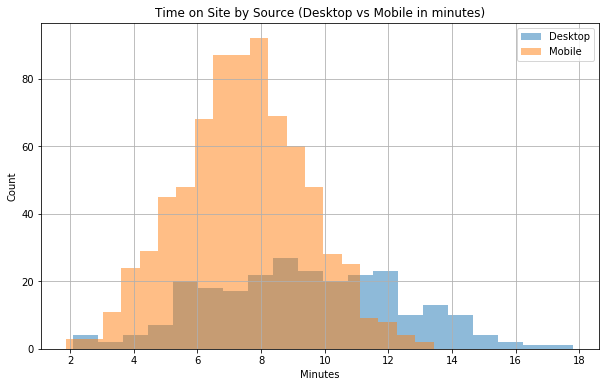

In [7]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site_min.hist(bins=20, alpha=0.5, figsize=(10,6))
plt.title('Time on Site by Source (Desktop vs Mobile in minutes)')
plt.ylabel('Count')
plt.xlabel('Minutes')
plt.legend(['Desktop', 'Mobile']);

In [8]:
user_data[user_data.time_on_site < 0.0]

,purchased,time_on_site,mobile,time_on_site_min


In [9]:
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site']

Series([], Name: time_on_site, dtype: float64)

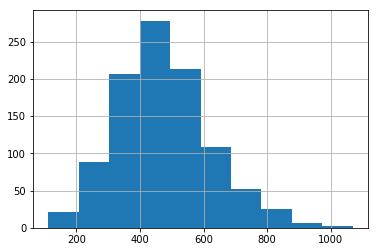

In [10]:
user_data.time_on_site.hist();

In [11]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,112.6943617331799,120.69393288384578,124.80420923358241,125.77716238998607,148.00984715951103,159.44999871237934,160.45652840574542,160.9562644158591,164.5101342591911,175.69679790281668,181.80040655324558,186.77077574202679,187.27767993068932,193.27839311398787,193.47439303099918,197.0661776503143,198.2031718242695,201.7571511811554,202.8266003588031,204.0707658830388,206.9283370391849,213.42996592031238,213.80896573416896,218.3740405725043,219.57265286155922,220.06180650651805,220.077617409131,221.2334191098706,222.7930053936418,222.90651569463463,224.25068259796873,226.1160874891014,226.2679351127249,229.38253705459522,230.0940848290716,230.187009737754,232.52482208262447,234.48887934805103,235.53811786573021,235.5716598645846,...,756.0053249302823,761.8624625436848,769.4793501251035,771.2754429583306,778.3121307977993,778.3979529067517,780.3716769069304,784.8677052568228,787.5677257908869,788.906205660323,789.5117666837625,798.2315570990341,805.0962946854088,806.5446131772061,809.5083426761875,812.6385711892063,817.4882406451252,818.2521939413234,818.5392056460405,818.5607350740613,822.704716382771,829.6174506262985,839.7792901701073,840.52294608477,844.9875947741311,852.0368288914575,863.2033720321369,864.1733610854911,870.5006494040167,872.1152909011694,872.1617425303903,874.6824486496823,880.4201451799527,888.3096155150715,909.3958300800966,923.6096922093429,929.2488910909558,943.2557561157971,1010.7020519681458,1068.7725006853611
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,0,0,1,1,1,1,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,...,1,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0
True,1,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,1,1,1,1,0,1,1,0,0,0,1,1,1,0,0,0,1,1,0,0,0,0,...,0,1,0,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,0,1,1,1,0,1,1,1,0,1,1,1,0,0,0,1,1,1,1,1,1


In [12]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site_min'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'], normalize='index')


purchased,False,True
time_on_site_min,,
"(1.862, 5.065]",0.550459,0.449541
"(5.065, 8.252]",0.472165,0.527835
"(8.252, 11.439]",0.429907,0.570093
"(11.439, 14.626]",0.376623,0.623377
"(14.626, 17.813]",0.250000,0.750000


In [13]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site_min,,
"(1.862, 5.065]",0.131004,0.090406
"(5.065, 8.252]",0.500000,0.472325
"(8.252, 11.439]",0.301310,0.337638
"(11.439, 14.626]",0.063319,0.088561
"(14.626, 17.813]",0.004367,0.011070


In [14]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.56,0.424
True,0.44,0.576


In [15]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased            False               True           
mobile               False     True      False     True 
time_on_site_min                                        
(1.862, 5.065]    0.085714  0.150943  0.036364  0.104167
(5.065, 8.252]    0.385714  0.550314  0.200000  0.541667
(8.252, 11.439]   0.350000  0.279874  0.390909  0.324074
(11.439, 14.626]  0.164286  0.018868  0.318182  0.030093
(14.626, 17.813]  0.014286  0.000000  0.054545  0.000000

In [16]:
!unzip jb084sr9005_nj_statewide_2019_02_25.csv.zip
!ls

Archive:  jb084sr9005_nj_statewide_2019_02_25.csv.zip
replace share/data/opp-for-archive/nj_statewide_2019_02_25.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: jb084sr9005_nj_statewide_2019_02_25.csv.zip  sample_data  share


In [17]:
%%time
df = pd.read_csv('./share/data/opp-for-archive/nj_statewide_2019_02_25.csv')
print(df.shape)


(3845334, 20)
CPU times: user 17.5 s, sys: 3.81 s, total: 21.3 s
Wall time: 21.3 s


In [18]:
df.head()

,raw_row_number,date,time,location,subject_race,subject_sex,officer_id_hash,department_id,type,violation,arrest_made,citation_issued,warning_issued,outcome,frisk_performed,search_conducted,vehicle_color,vehicle_make,vehicle_model,vehicle_registration_state
0,24723,2009-01-10,15:38:41,"31ST / CARMEN, Camden City",black,male,347f40fd4d,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,SIL,Chrysler,Town & Country,NJ
1,88239,2009-02-06,11:34:36,"@division, Ewing Twp",black,female,e84e551aad,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101999,2009-02-11,01:34:26,"34TH / WESTFIELD, Camden City",black,male,e008ccd5a2,A010,vehicular,NaN,True,NaN,NaN,arrest,False,True,GRY,Chevrolet,NaN,PA
3,151289,2009-03-03,20:29:16,"MACARTHUR / 12TH, Camden City",black,male,b84c0f827e,A010,vehicular,NaN,True,NaN,NaN,arrest,True,True,BLU,Chevrolet,Tahoe,NJ
4,153223,2009-03-05,22:25:26,"FEDERAL / 10TH, Camden City",black,male,56eb37f85f,A010,vehicular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BLK,Ford,Expedition,NJ


In [19]:
df.isna().sum()

raw_row_number                      0
date                                0
time                                0
location                            0
subject_race                   109431
subject_sex                     18787
officer_id_hash                     0
department_id                       0
type                                0
violation                      916990
arrest_made                   3719812
citation_issued                852818
warning_issued                 858842
outcome                        845936
frisk_performed               3707675
search_conducted              3703294
vehicle_color                  102890
vehicle_make                   143182
vehicle_model                 2887636
vehicle_registration_state      27617
dtype: int64

In [20]:
df.violation.value_counts().head(10)

39:4-97 CARELESS DRIVING                          726267
39:4-98 RATES OF SPEED                            301189
39:4-88B UNSAFE LANE CHANGE                       218747
39:3-76.2F REQ WEARING SEATBELTS                  189408
39:4-56 DELAYING TRAFFIC                          165038
39:3-66 MAINTENANCE ILLUM DEVICE                  139425
39:4-97.3 USE OF HANDS-FREE WIRELESS TELEPHONE    126905
39:4-99 EXCEED SPEED LIMITATIONS                   96289
39:3-75 SAFETY GLASS DEFINED                       82905
39:3-74 WINDSHIELD WIPERS                          73668
Name: violation, dtype: int64

In [21]:
df.vehicle_make.value_counts(normalize=True).head(10)

Honda         0.118632
Ford          0.106514
Toyota        0.099623
Chevrolet     0.084403
Nissan        0.081274
Dodge         0.047225
Hyundai       0.037378
Jeep          0.035211
BMW           0.034904
Volkswagen    0.028908
Name: vehicle_make, dtype: float64

In [22]:
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_make.value_counts(normalize=True).head(10)

Honda            0.125034
Toyota           0.107939
Ford             0.088320
Nissan           0.084921
Chevrolet        0.074299
BMW              0.043302
Dodge            0.041296
Hyundai          0.039327
Volkswagen       0.032925
Mercedes-Benz    0.031556
Name: vehicle_make, dtype: float64

In [23]:
df[df.violation == '39:4-98 RATES OF SPEED'].vehicle_color.value_counts(normalize=True).head(10)

BLK    0.238954
SIL    0.200708
WHI    0.157833
GRY    0.110433
BLU    0.096752
RED    0.077175
GRN    0.043044
TAN    0.020111
GLD    0.019722
BGE    0.009164
Name: vehicle_color, dtype: float64

In [24]:
df = pd.DataFrame({'a': np.arange(1e6),
                   'b': 2*np.arange(1e6)})
print(df.shape)
df.head()

(1000000, 2)


,a,b
0,0.0,0.0
1,1.0,2.0
2,2.0,4.0
3,3.0,6.0
4,4.0,8.0


In [25]:
%timeit df['c'] = df['a']**2

100 loops, best of 3: 13.4 ms per loop


In [26]:
%timeit df['c2'] = df['a'].apply(lambda x: x**2)

1 loop, best of 3: 317 ms per loop


In [27]:
df.head()

,a,b,c,c2
0,0.0,0.0,0.0,0.0
1,1.0,2.0,1.0,1.0
2,2.0,4.0,4.0,4.0
3,3.0,6.0,9.0,9.0
4,4.0,8.0,16.0,16.0


In [28]:
from tqdm import tqdm
tqdm.pandas(desc="my bar!")
%timeit df['c2'] = df['a'].progress_apply(lambda x: x**2)

my bar!: 100%|██████████| 1000000/1000000 [00:01<00:00, 698770.81it/s]

1 loop, best of 3: 1.44 s per loop


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

In [87]:
df = pd.read_csv('https://raw.githubusercontent.com/deanhadzi/DS-Unit-1-Sprint-1-Dealing-With-Data/master/module3-databackedassertions/persons.csv', index_col=0)
print(df.shape)
df.head()

# Importing data frame for this module's homework.
# Making sure it was loaded properly.

(1200, 3)


,age,weight,exercise_time
0,44,118,192
1,41,161,35
2,46,128,220
3,39,216,57
4,28,116,182


In [88]:
df.isna().sum()

# All data is present and accounted for.

age              0
weight           0
exercise_time    0
dtype: int64

In [89]:
df.describe()

# Checking the central tendency, dispersion and shape of a dataset’s distribution

,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000
mean,48.396667,153.540833,134.910833
std,18.166802,35.132182,85.548895
min,18.000000,100.000000,0.000000
25%,33.000000,125.000000,65.000000
50%,48.000000,149.000000,122.000000
75%,64.000000,180.250000,206.000000
max,80.000000,246.000000,300.000000


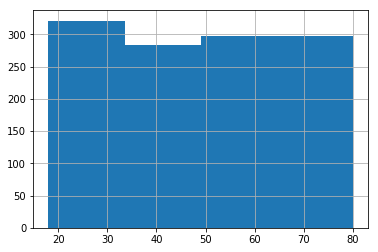

In [106]:
df.age.hist(bins=4)

# I noticed above that age has almost uniform distribution.
# Histogram plotted to show it in 4 bins. 

In [90]:
df['below_average_weight'] = np.where(df['weight'] <= 177.9, 'True', 'False')
df.head()

# Creating the new feature which will return True or False if person is below average USA weight based on this article:
# https://en.wikipedia.org/wiki/Human_body_weight

,age,weight,exercise_time,below_average_weight
0,44,118,192,True
1,41,161,35,True
2,46,128,220,True
3,39,216,57,False
4,28,116,182,True


In [97]:
age_bins = pd.qcut(df['age'], 4)  # 4 equal-sized bins
pd.crosstab(age_bins, df['below_average_weight'], normalize='columns')

# Crosstabulating the age bins with average weight.
# As expected younger population is below average weight more often than the older population.

below_average_weight,False,True
age,,
"(17.999, 33.0]",0.207547,0.289116
"(33.0, 48.0]",0.207547,0.246032
"(48.0, 64.0]",0.238994,0.251701
"(64.0, 80.0]",0.345912,0.213152


In [93]:
# Based on HHS.gov adults should exercise between 150-300 mintues per week.
# Since 300 minutes is cap in our sample we will set anyone below 150 minutes per week to low category.
# https://www.hhs.gov/fitness/be-active/physical-activity-guidelines-for-americans/index.html

df['exercise_amount'] = np.where(df['exercise_time'] < 150, 'low', 'normal')
                        
df.head()

,age,weight,exercise_time,below_average_weight,exercise_amount
0,44,118,192,True,normal
1,41,161,35,True,low
2,46,128,220,True,normal
3,39,216,57,False,low
4,28,116,182,True,normal


In [98]:
pd.crosstab(age_bins, df['exercise_amount'], normalize='columns')

# Cross referncing the age with amount of exercise. Again, youngsters have the lead.

exercise_amount,low,normal
age,,
"(17.999, 33.0]",0.216643,0.337972
"(33.0, 48.0]",0.202296,0.282306
"(48.0, 64.0]",0.209469,0.302187
"(64.0, 80.0]",0.371593,0.077535


In [96]:
# My hypothesis will be that person who is younger will exercise longer.
# Also the person who is below average weight will exercise longer.

pd.crosstab(age_bins, [df['below_average_weight'], df['exercise_amount']], normalize='columns')

below_average_weight     False                True          
exercise_amount            low    normal       low    normal
age                                                         
(17.999, 33.0]        0.200000  0.285714  0.228501  0.341053
(33.0, 48.0]          0.203448  0.250000  0.201474  0.284211
(48.0, 64.0]          0.231034  0.321429  0.194103  0.301053
(64.0, 80.0]          0.365517  0.142857  0.375921  0.073684

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)